# Sking Cancer Images Classification with Deep Learning

## Import modules

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        continue

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Or "jax" or "torch"!

import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import seaborn as sns
from keras import layers
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import random



2024-08-25 13:34:07.224746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 13:34:07.224873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 13:34:07.350853: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


## Read input data

The metadata file contains, among other information, the class of each of the images (the type of cancer)

In [4]:
metadata = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


We are going to code the possible classes with integer codes. The "class_code" and "class_name" dictionaries will be useful to code and uncode the images classes

In [6]:
class_code = {dx:code for code, dx in enumerate(metadata["dx"].unique())}
print(class_code)


{'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}


In [7]:
class_name = {code:dx for code, dx in enumerate(metadata["dx"].unique())}
print(class_name)

{0: 'bkl', 1: 'nv', 2: 'df', 3: 'mel', 4: 'vasc', 5: 'bcc', 6: 'akiec'}


The dataset is stored in 2 directories. We are going to read the images and store them in a keras dataset and split it into "train_ds", for the neural network (NN) training, and "test_ds", for the NN testing 

In [8]:
BATCH_SIZE = 5

def get_coded_labels(directory, metadata, class_code):
    coded_labels = (
        pd.DataFrame({ "image_id" : [x[:-4] for x in os.listdir(directory)]})
        .sort_values("image_id")
        .merge(metadata, on = "image_id", how="inner")["dx"]
        .map(lambda x: class_code.get(x)))
    return list(coded_labels)


dataset_part1 = keras.utils.image_dataset_from_directory(
    directory = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1",
    labels = get_coded_labels("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1", metadata, class_code),
    batch_size=BATCH_SIZE,
    label_mode= "categorical",
    
)
dataset_part2 = keras.utils.image_dataset_from_directory(
    directory = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2",
    labels = get_coded_labels("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2", metadata, class_code),
    batch_size=BATCH_SIZE,
    label_mode= "categorical"
)
train_ds, test_ds = keras.utils.split_dataset(
    dataset = dataset_part1.concatenate(dataset_part2),
    left_size=0.8,
    shuffle=True)




Found 5000 files belonging to 7 classes.
Found 5015 files belonging to 7 classes.


## Exploratory Data Analysis

Let's explore the dimension of the training dataset

In [9]:
tf.data.DatasetSpec.from_value(train_ds)

DatasetSpec((TensorSpec(shape=(5, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5, 7), dtype=tf.float32, name=None)), TensorShape([]))

The training dataset contains 256x256 images with 3 channels (RGB) in batches of 5 images

In [10]:
card = train_ds.cardinality().numpy()*BATCH_SIZE
card

8010

There is a total of 8010 images in the training dataset.

Now let´s look at a few images fo this dataset

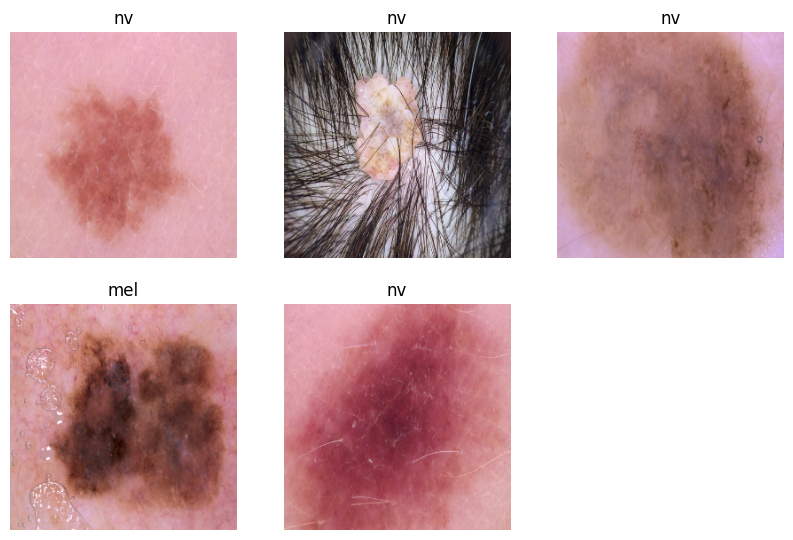

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    im_shape = tf.shape(images[0])
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(class_name.get(labels[i]))
        plt.title(class_name.get(pd.from_dummies(pd.DataFrame(labels)).iloc[i,0]))
        plt.axis("off")

Let's also look at the distribution of the training dataset images by class type

/tmp/ipykernel_34/3659382834.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_label_df = pd.concat([


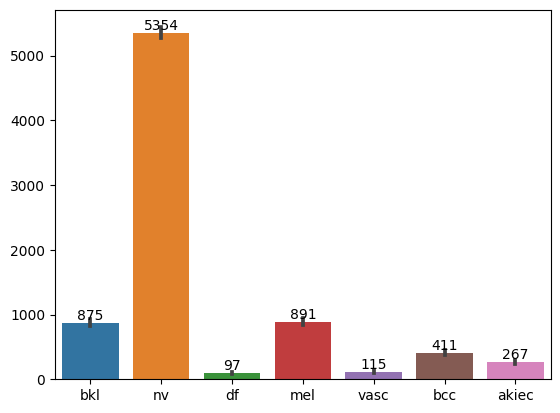

In [12]:
train_label_df = pd.DataFrame(columns = class_code.keys())
for images, labels in train_ds.as_numpy_iterator():
    train_label_df = pd.concat([
        train_label_df,
        pd.DataFrame(columns=class_code.keys(), data= labels)
    ])

ax = sns.barplot(train_label_df*card)
for i in ax.containers:
    ax.bar_label(i,)

In [13]:
train_label_df.sum()

bkl       875.0
nv       5354.0
df         97.0
mel       891.0
vasc      115.0
bcc       411.0
akiec     267.0
dtype: float32

This training dataset is highly imbalanced, more than half of the training images belong to the class "nv", while less than 1000 samples belong to the rest of the clases.

 ## Data Augmentation

Having too little samples for some classes of the dataset will often lead neural networks to overfit and be biased. To deal with this, first, we are going to create a data augmentation function that, given an image, will introduce a random flip and a random rotation. This will help to increase the training dataset and increase the regularization (prevention of overfitting) of the resulting model

In [14]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images



Let's see how the augmentation works with a sample image

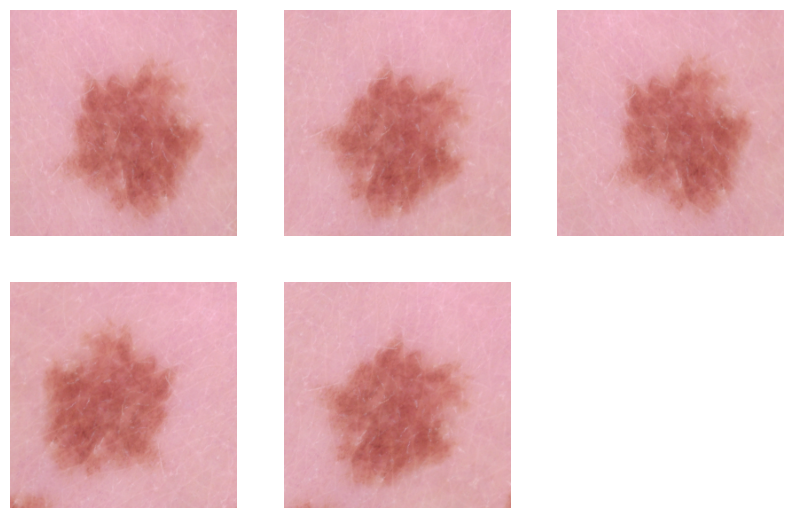

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(5):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

## Neural Network set up and training

To create our NN classification model, given that we have a small dataset for some classes, we are going to fine-tune an existing pre-trained NN called [InceptionV3](https://arxiv.org/abs/1512.00567v3). We are going to include some additional top layers including a dropout layer, which is another regularization technique to avoid overfitting.

In [16]:
inputs = keras.Input(shape = tuple(im_shape.numpy()))

base_model = InceptionV3(weights="imagenet", include_top=False)

# Freeze the base_model
base_model.trainable = False

x = data_augmentation(inputs)
x = layers.Rescaling(scale=1./255)(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(class_code.keys()), activation = 'softmax')(x)


model = Model(inputs = inputs, outputs = outputs)

model.summary(show_trainable=True)



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ inception_v3 (Functional)   │ (None, 6, 6, 2048)    │ 21,802,784 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 512)           │  1,049,088 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 256)           │    131,328 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 7)             │        903 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 23,016,999 (87.80 MB)

 Trainable params: 1,214,215 (4.63 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Now we are going to train the model. To avoid losing the "knowledge" from the pre-trained NN and train the whole network more efficiently, we have frozen the InceptionV3 layer parameters

In [17]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics = [keras.metrics.Precision(), keras.metrics.Recall()])

epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

print("Fitting the top layer of the model")
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds,
)

Fitting the top layer of the model
Epoch 1/10
   3/1602 ━━━━━━━━━━━━━━━━━━━━ 1:01 39ms/step - loss: 2.1022 - precision: 0.5556 - recall: 0.1222          

I0000 00:00:1724592973.054215     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724592973.120483     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1601/1602 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9824 - precision: 0.7971 - recall: 0.5753

W0000 00:00:1724593011.826111     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1602/1602 ━━━━━━━━━━━━━━━━━━━━ 69s 29ms/step - loss: 0.9823 - precision: 0.7971 - recall: 0.5753 - val_loss: 0.8410 - val_precision: 0.8837 - val_recall: 0.5382
Epoch 2/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 0.7813 - precision: 0.8447 - recall: 0.6154 - val_loss: 0.7969 - val_precision: 0.8732 - val_recall: 0.5840
Epoch 3/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.7227 - precision: 0.8476 - recall: 0.6496 - val_loss: 0.7851 - val_precision: 0.8209 - val_recall: 0.6219
Epoch 4/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 0.6784 - precision: 0.8502 - recall: 0.6745 - val_loss: 0.7930 - val_precision: 0.8028 - val_recall: 0.6274
Epoch 5/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 0.6418 - precision: 0.8505 - recall: 0.6842 - val_loss: 0.7668 - val_precision: 0.8031 - val_recall: 0.6733
Epoch 6/10
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - loss: 0.6047 - precision: 0.8564 - recall: 0.7169 - val_loss: 0.8359 - val_precision: 0.7940 

Now let's have a look at the evolution of the loss function with each epoch

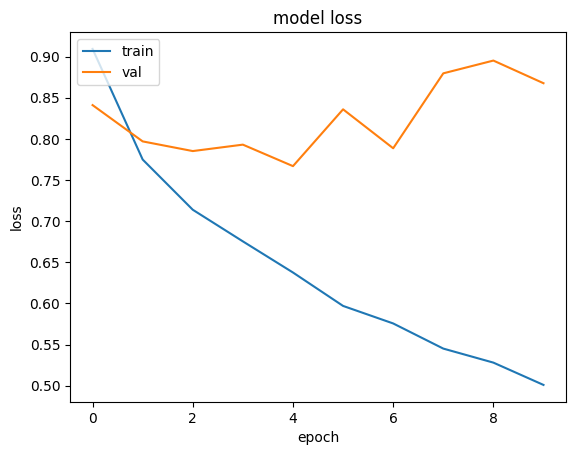

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

We see that after 3 epochs, the loss function of the validation dataset doesn´t improve meaningfully. This means that if we continue training the model it will start overfitting the training dataset.

Now we are going to unfreeze the InceptionV3 parameters to be trained and we give one last epoch of training to the whole model

In [22]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss='categorical_crossentropy', 
              metrics = [keras.metrics.Precision(), keras.metrics.Recall()])
epochs = 1
print("Fitting the end-to-end model")
history2 = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds,
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ inception_v3 (Functional)   │ (None, 6, 6, 2048)    │ 21,802,784 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 512)           │  1,049,088 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 256)           │    131,328 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 7)             │        903 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 68,982,135 (263.15 MB)

 Trainable params: 22,982,567 (87.67 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 45,965,136 (175.34 MB)

Fitting the end-to-end model
   2/1602 ━━━━━━━━━━━━━━━━━━━━ 3:08 118ms/step - loss: 0.3390 - precision_2: 1.0000 - recall_2: 0.9500  

W0000 00:00:1724594877.463542     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1602/1602 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.5470 - precision_2: 0.8909 - recall_2: 0.7295

W0000 00:00:1724594995.744226     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1602/1602 ━━━━━━━━━━━━━━━━━━━━ 194s 80ms/step - loss: 0.5470 - precision_2: 0.8909 - recall_2: 0.7295 - val_loss: 0.8896 - val_precision_2: 0.7872 - val_recall_2: 0.6993


We have finally obtained a trained model to classify our skin cancer images

Now let's see how the model works with a random sample of images from the test dataset (rerun this step several times to see predictions with different images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


W0000 00:00:1724595037.160683     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


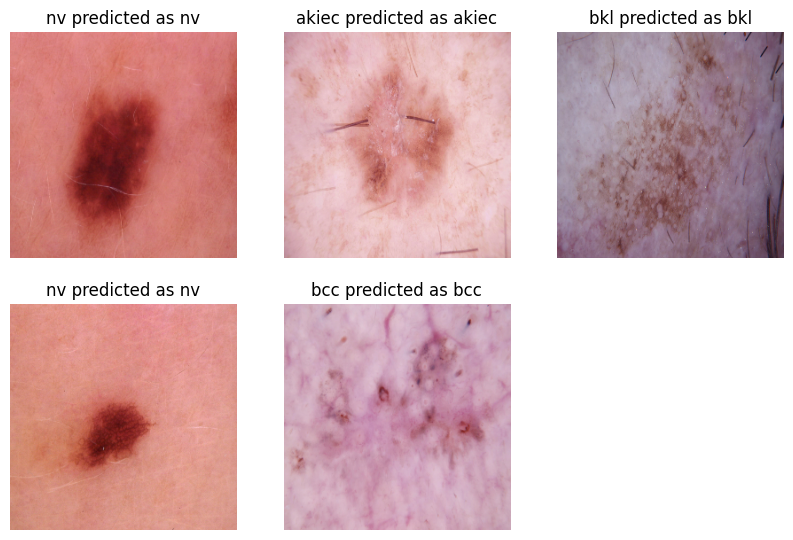

In [23]:
plt.figure(figsize=(10, 10))
test_ds = test_ds.shuffle(buffer_size=test_ds.cardinality())
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        # plt.title(f"{labels[i]} predicted as {np.argmax(predictions[i])}")
        plt.title(f"{class_name.get(pd.from_dummies(pd.DataFrame(labels)).iloc[i,0])} predicted as {class_name.get(np.argmax(predictions[i]))}")
        plt.axis("off")

The model makes the right prediction the majority of times but we can see it struggles to differentiate certain tumours that looks very alike. 